In [60]:
import os
os.environ['PYSPARK_PYTHON'] = 'python'

In [61]:
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
from pyspark.sql.functions import col

In [62]:
spark = SparkSession.builder.appName("Join").getOrCreate()

# Part a) Frequency of Air Travel

In [63]:
# loading the dataset using pyspark
flying = spark.read.csv("flying.csv", header = True, inferSchema = True)

In [64]:
# frequency groups and their counts
freq_counts = (
    flying
    .groupBy("frequency")
    .count()
    .orderBy(col("count").desc())
)

In [65]:
# converting to pandas for plotting
pdf = freq_counts.toPandas()

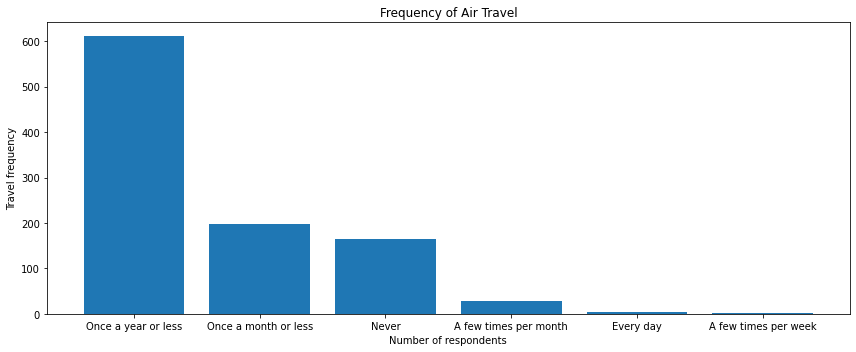

In [66]:
# using matplotlib to plot a bar grpah
plt.figure(figsize=(12, 5))
plt.bar(pdf["frequency"], pdf["count"])
plt.title("Frequency of Air Travel")
plt.xlabel("Number of respondents")
plt.ylabel("Travel frequency")
plt.tight_layout()
plt.show()

### We can see that there are about 600 people who travel by plane once a year, which is the most in this dataset. The second frequent category is once a month or less, which is almost 200 people. Additionally, around 180 people never travel by plane, according to this dataset. Lastly, people flying every day and a few time a week is very low, which is not significant.

# Part b) Children and Attitudes Toward Babies on Planes

In [67]:
b_clean_df = flying.dropna(
    subset=["children_under_18", "baby"]
)

In [68]:
crosstab_df = (
 b_clean_df
    .groupBy("children_under_18", "baby")
    .count()
    .orderBy("children_under_18", "baby")
)

# Convert to Pandas for plotting
pdf = crosstab_df.toPandas()

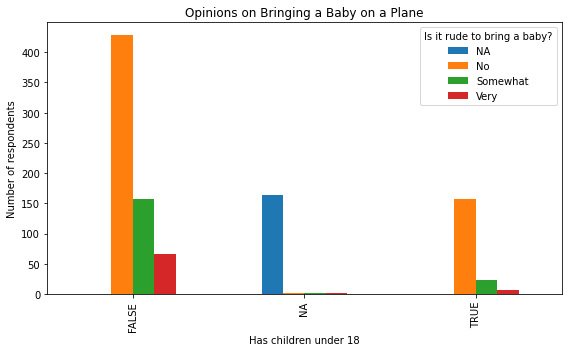

In [69]:

pivot_df = pdf.pivot(
    index="children_under_18",
    columns="baby",
    values="count"
)

pivot_df.plot(
    kind="bar",
    figsize=(8, 5)
)

plt.title("Opinions on Bringing a Baby on a Plane")
plt.xlabel("Has children under 18")
plt.ylabel("Number of respondents")
plt.legend(title="Is it rude to bring a baby?")

plt.tight_layout()
plt.show()

### People without children mostly say bringing a baby on a plane is not rude. Some also say it is somewhat or very rude. Most people with children also say it is not rude, but fewer of them say it is rude compared to people without children.
### Views of parents and non-parents differ. Parent are more tolerant to having babies on plane. Meanwhile, non-parent are likely to find it rude to have babies on a plane.

# Part c) Age Groups and Reclining Seats Behavior

In [70]:
part_c_df = flying.filter(
    col("age").isNotNull() & col("recline_rude").isNotNull()
)

In [71]:
contingency_table = (
    part_c_df
    .groupBy("age", "recline_rude")
    .count()
    .orderBy("age")
)

contingency_table.show()


+-----+------------+-----+
|  age|recline_rude|count|
+-----+------------+-----+
|18-29|          No|   78|
|18-29|        Very|   20|
|18-29|          NA|   48|
|18-29|    Somewhat|   74|
|30-44|        Very|   15|
|30-44|          No|  143|
|30-44|    Somewhat|   64|
|30-44|          NA|   32|
|45-60|          No|  140|
|45-60|    Somewhat|   80|
|45-60|          NA|   41|
|45-60|        Very|   14|
| > 60|          No|  133|
| > 60|    Somewhat|   61|
| > 60|          NA|   43|
| > 60|        Very|   21|
+-----+------------+-----+



In [72]:
total_by_age = (
    part_c_df
    .groupBy("age")
    .count()
    .withColumnRenamed("count", "total")
)
rude_by_age = (
    part_c_df
    .filter(col("recline_rude").isin("Somewhat", "Very"))
    .groupBy("age")
    .count()
    .withColumnRenamed("count", "rude_count")
)


In [73]:
percent_rude = (
    total_by_age
    .join(rude_by_age, on="age", how="left")
    .fillna(0, subset=["rude_count"])
    .withColumn(
        "percent_rude",
        round((col("rude_count") / col("total")) * 100, 2)
    )
    .orderBy("age")
)

percent_rude.show()


+-----+-----+----------+------------+
|  age|total|rude_count|percent_rude|
+-----+-----+----------+------------+
|18-29|  220|        94|       42.73|
|30-44|  254|        79|        31.1|
|45-60|  275|        94|       34.18|
| > 60|  258|        82|       31.78|
+-----+-----+----------+------------+



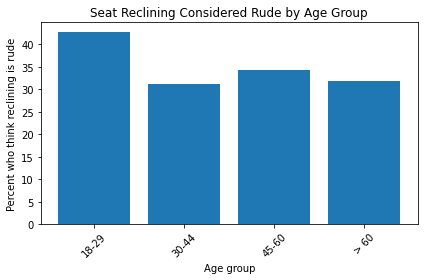

In [74]:
pdf = percent_rude.select("age", "percent_rude").toPandas()
plt.figure()
plt.bar(pdf["age"], pdf["percent_rude"])
plt.xlabel("Age group")
plt.ylabel("Percent who think reclining is rude")
plt.title("Seat Reclining Considered Rude by Age Group")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

### Younger age group (18-29) show a higher percentage of respondents who consider seat reclining rude. Older respondents, groups 30-44 and >60, are more likely to say reclining is not that rude.
### Overall, tolerance for reclining is slightly higher in younger age groups than in mid to older age groups.

# Part d) Alcohol Consumption and General Rudeness Perceptions

### N/A: No columns regarding alcohol consumption and rudeness preception